# Demonstration RAG-Eval


In [10]:
from rag_eval.protocol import LLMClient
from rag_eval.client import AzureClient
from rag_eval.components import ClaimExtractor, EntailmentJudge
from rag_eval.data_models import EvalContainer, ClaimVerdict
from rag_eval.evaluators import AnswerPrecisionEvaluator, RetrievalPrecisionEvaluator
from rag_eval.coordinator import RAGEvaluator
from rag_eval.helpers import _safe_json
import json
from data.rag_eval_samples import test_examples
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

In [11]:
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# Test Agent

Check if agent module actually works.

In [12]:
# load agent and pipeline for indexing docs
import agent.main as main
from rag.indexing import pdf_files, index_pipeline

In [13]:
index_pipeline.run({"converter": {"sources": pdf_files}})

incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


{'writer': {'documents_written': 51}}

## RAG-Loop
Loop which passes questions to agent and extracts generated answers alongside retrieved contexts (plain text). Combines them with ground truth and query to form `EvalContainer`-object.

In [5]:
# quick test of my query_gt_extractor function
from src.rag_eval.helpers import query_gt_extractor

queries, gt = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)
print(len(queries), len(gt))


40 40


This code cell creates a RAG-loop for the agent. It:  
- feeds the questions from the test battery to the agent  
- extracts the generated answer and retrieved context from the RAG-call
- returns a list of `EvalContainer`-objects storing question, ground truth, generated answer and retrieved context

It thus lays the foundation for the `RAGEevaluator`. 

In [14]:
main.food_agent(user_input="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?")


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.01it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Espresso kostet bei Anton's Pizza 2,00 €; bei Il sogno de Anton ist kein Espresso-Preis angegeben, daher ist er bei Anton's Pizza teurer belegbar.


{'answer': "Espresso kostet bei Anton's Pizza 2,00 €; bei Il sogno de Anton ist kein Espresso-Preis angegeben, daher ist er bei Anton's Pizza teurer belegbar.",
 'token_usage': {'prompt': 5152, 'completion': 101, 'total': 5253},
 'calls': [{'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 789, 'completion': 28, 'total': 817}},
  {'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 1759, 'completion': 30, 'total': 1789}},
  {'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 2604, 'completion': 43, 'total': 2647}}],
 'rag_calls': 2}

In [15]:
from src.rag_eval.eval_loop import rag_loop_agent

# commented out because I save the resulting data object to avoid frequent execution
result, token_usage, failures = rag_loop_agent()


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.49it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Top K is: 5

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Getränke Espresso Preis Il sogno de Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Top K is: 7

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Anton's Pizza kostet ein Espresso 2,00 €. Für Il sogno de Anton konnte kein Espresso-Preis gefunden werden, daher ist nur Anton's Pizza eindeutig mit Preis belegt.


TypeError: 'NoneType' object is not subscriptable

In [13]:
# EXECUTE ME
print(len(result))

40


In [7]:
# show eval containers
#print(result)

import pickle

#save result
with open("result.pkl", "wb") as f:
        pickle.dump(result, f)

# access pickled result
with open("result.pkl", "rb") as f:
    result = pickle.load(f)

data = result


with open("token_usage.pkl", "wb") as f:
        pickle.dump(token_usage, f)

# access pickled result
with open("token_usage.pkl", "rb") as f:
    token_usage = pickle.load(f)

token_usage = token_usage


In [8]:
print(data)

[EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im bereitgestellten Kontext ist kein Preis für einen Espresso bei Anton's Pizza oder bei Il sogno de Anton aufgeführt. Die Getränkekarten und Preise listen zwar verschiedene Speisen und Getränke auf, einen Espresso oder dessen Preis findet man jedoch nicht in den genannten Auszügen. Daher kann leider nicht beantwortet werden, wie viel ein Espresso bei diesen Restaurants kostet.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €

In [16]:
print(len(data))

40


## Evaluation of Agentic RAG with RAGEvaluator


In [8]:
# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

In [9]:
# create EvalContainer-object for each question-ground truth-pair 
#from src.rag_eval.eval_loop import rag_loop_agent
import pandas as pd
#result = rag_loop_agent()

# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

# run rag_evaluation and extract metrics from it 

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(data):
    #iteration tracker
    print(f"=== ITERATION-No. {i} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])

=== ITERATION-No. 0 ===
=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===


In [11]:
#print(answer_recall)

In [10]:
# #turn data into df for visualisation
df_data_agentic = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision
 }
df_agentic = pd.DataFrame(df_data_agentic)

print(df_agentic)

df_agentic.to_csv("df_agentic.csv", index=True)


    answer_recall  answer_precision  retrieval_recall  retrieval_precision
0        0.000000          0.000000          0.000000             0.000000
1        0.666667          0.500000          0.666667             0.200000
2        0.800000          0.361111          0.000000             0.200000
3        0.000000          0.000000          0.000000             0.000000
4        0.833333          0.437500          0.666667             0.200000
5        0.000000          0.000000          0.000000             0.000000
6        0.000000          0.000000          0.000000             0.000000
7        0.500000          0.062500          0.500000             0.000000
8        0.000000          0.000000          0.000000             0.000000
9        0.125000          0.357143          0.375000             0.400000
10       0.000000          0.000000          0.000000             0.000000
11       0.000000          0.000000          0.000000             0.000000
12       0.400000        

In [12]:
print(token_usage)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [21]:
df_agentic = pd.read_csv("df_agentic.csv")
df_agentic.describe()

,Unnamed: 0,answer_recall,answer_precision,retrieval_recall,retrieval_precision
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,19.500000,0.650843,0.395225,0.631220,0.152500
std,11.690452,0.345789,0.329411,0.344637,0.093336
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.750000,0.400000,0.111538,0.333333,0.100000
50%,19.500000,0.690476,0.333333,0.666667,0.100000
75%,29.250000,1.000000,0.600000,1.000000,0.200000
max,39.000000,1.000000,1.000000,1.000000,0.400000


## Evaluation Plain RAG

In [8]:
from src.rag_eval.data_models import EvalContainer
from src.rag.retrieval import basic_rag
from src.rag_eval.helpers import query_gt_extractor

queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)

# initiate lists to store EvalContainer-Ojbects
eval_conts = []
predicted_answers = []
retrieved_contexts = []
token_usage = []

for idx, query in enumerate(queries):

    # run RAG
    result = basic_rag.run({"query_embedder":{"text": query}, 
                            "prompt_builder":{"question": query}}, 
                            include_outputs_from="retriever")
    
    # store generated answer
    predicted_answers.append(result["llm"]["replies"][0])
    
    # for each question, store content from Document-object in list
    docs = result["retriever"]["documents"]
    retrieved_contexts.append([d.content for d in docs])

    # extract what is needed for EvalContainer-object
    query = queries[idx]
    ground_truth_answer = gts[idx]
    retrieved_texts = retrieved_contexts[idx]
    generated_answer = predicted_answers[idx]

    eval_cont = EvalContainer(query=query,
                                ground_truth_answer=ground_truth_answer,
                                generated_answer=generated_answer,
                                retrieved_texts=retrieved_texts # BUGFIX: retrieved_texts MUST be list, otherwise RetrievalPrecisionEvaluator will treat each letter of retrieved_texts as a doc_text
                                )
    # get number of tokens used 
    usage = None
    if "llm" in result and "usage" in result["llm"]:
        usage = result["llm"]["usage"]  # often contains prompt_tokens, completion_tokens, total_tokens

    
    eval_conts.append(eval_cont)
    token_usage.append(usage)

    


c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
No Documents found with embeddings.

In [9]:
print(eval_conts[0])

EvalContainer(query="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Es liegen keine Preisinformationen von Anton's Pizza und Il sogno de Anton für Espresso im gegebenen Kontext vor. Daher kann ich den Preisvergleich nicht durchführen und nicht sagen, wo der Espresso teurer ist.", retrieved_texts=[])


In [16]:
print(eval_conts[0])

EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im gegebenen Kontext sind keine Preise für Espresso bei Anton's Pizza oder Il sogno de Anton aufgeführt. Daher lässt sich nicht beantworten, in welchem Restaurant der Espresso mehr kostet und wie hoch die jeweiligen Preise sind.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate,

In [17]:
import pandas as pd
import importlib
import src.rag_eval.evaluators as evaluators
import rag_eval.coordinator as coordinator

importlib.reload(evaluators)  # force reimport after changes
importlib.reload(coordinator)


# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(eval_conts):
    #iteration tracker
    print(f"=== ITERATION-No. {i+1} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])


=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===
=== ITERATION-No. 40 ===


In [13]:
    # turn data into df for visualisation
df_data_plain_rag = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision
}

df_plain_rag = pd.DataFrame(df_data_plain_rag)

#print(df_plain_rag)

df_plain_rag.to_csv("df_plain_rag.csv", index=True)


# Visualize Results

In [4]:
print(df_agentic_rag.describe())

       answer_recall  answer_precision  retrieval_recall  retrieval_precision
count      40.000000         40.000000         40.000000            40.000000
mean        0.325982          0.173850          0.283839             0.169881
std         0.338159          0.265323          0.342722             0.239816
min         0.000000          0.000000          0.000000             0.000000
25%         0.000000          0.000000          0.000000             0.000000
50%         0.266667          0.000000          0.083333             0.142857
75%         0.500000          0.339286          0.500000             0.212500
max         1.000000          1.000000          1.000000             1.000000


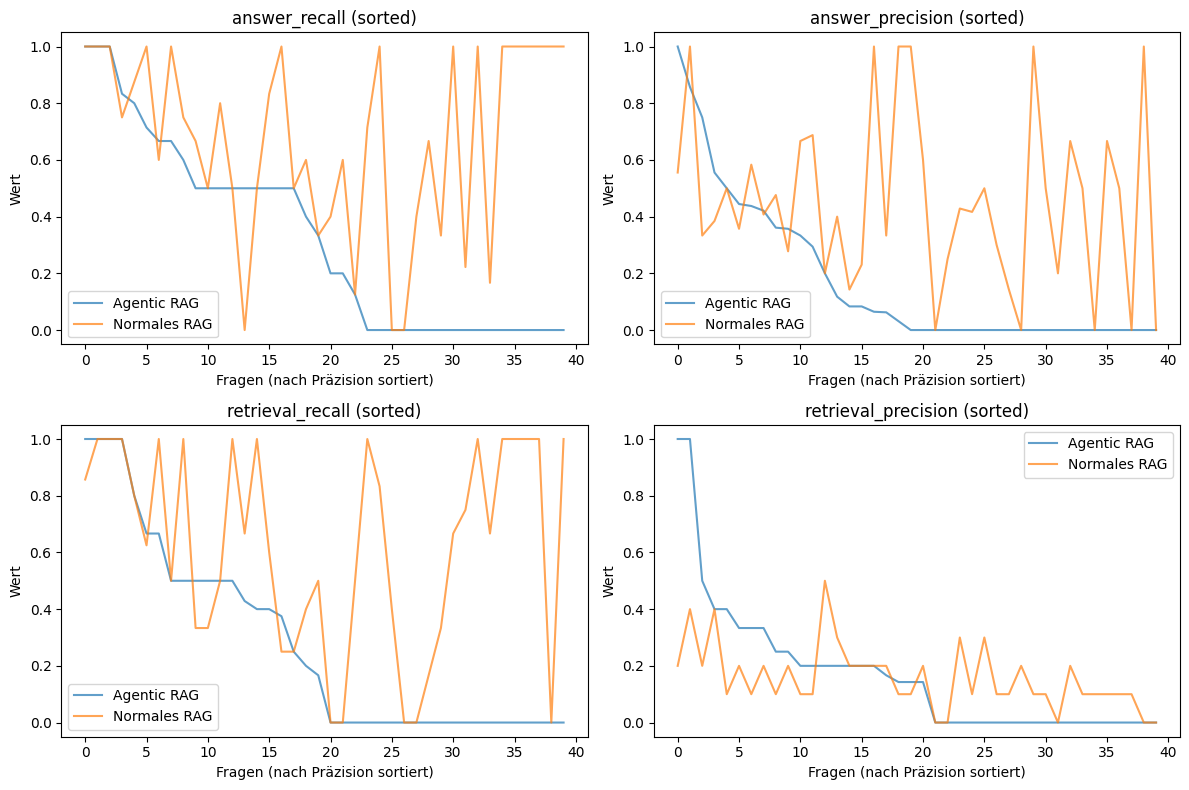

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# import data
df_agentic_rag = pd.read_csv("df_agentic.csv", index_col=False).drop(columns=["Unnamed: 0"])
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

columns = df_agentic_rag.columns  

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]

    # sort both series by agentic metric value (descending)
    order = df_agentic_rag[col].sort_values(ascending=False).index
    agentic_sorted = df_agentic_rag.loc[order, col].reset_index(drop=True)
    plain_sorted   = df_plain_rag.loc[order, col].reset_index(drop=True)

    ax.plot(agentic_sorted.index, agentic_sorted, label="Agentic RAG", alpha=0.7)
    ax.plot(plain_sorted.index, plain_sorted, label="Normales RAG", alpha=0.7)

    ax.set_title(f"{col} (sorted)")
    ax.set_xlabel("Fragen (nach Präzision sortiert)")
    ax.set_ylabel("Wert")
    ax.legend()

plt.tight_layout()
plt.show()



In [ ]:
df_agentic_rag.